In [1]:
! pip install gwpy bilby dynesty lalsuite

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from gwpy.timeseries import TimeSeries, TimeSeriesDict
import gwpy

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import astropy
from astropy import units as u
import astropy.constants as const
from gwpy.plot import Plot
from scipy.stats import linregress

import bilby
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

import warnings
warnings.filterwarnings("ignore")

In [3]:
t_c = 1564316116.4
post_trigger_duration = 1
duration = 2
start = t_c + post_trigger_duration  - duration
end = start + duration

In [4]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("V1")
V1 = bilby.gw.detector.get_empty_interferometer("L1")

In [5]:
H1_data = TimeSeries.read('H1.gwf', 'H1:HWINJ_INJECTED')
H1_data_clip = H1_data[(H1_data.times>start*u.s) & (H1_data.times<end*u.s)]
H1.set_strain_data_from_gwpy_timeseries(H1_data_clip)

L1_data = TimeSeries.read('L1.gwf', 'L1:HWINJ_INJECTED')
L1_data_clip = L1_data[(L1_data.times>start*u.s) & (L1_data.times<end*u.s)]
L1.set_strain_data_from_gwpy_timeseries(L1_data_clip)

V1_data = TimeSeries.read('V1.gwf', 'V1:HWINJ_INJECTED')
V1_data_clip = V1_data[(V1_data.times>start*u.s) & (V1_data.times<end*u.s)]
V1.set_strain_data_from_gwpy_timeseries(V1_data_clip)

In [44]:
psd_alpha = 2*H1.strain_data.roll_off/duration
H1_psd = (H1_data/u.ct).psd(fftlength = duration, overlap = 0, window = ("tukey", psd_alpha ), method = 'median')
L1_psd = (V1_data/u.ct).psd(fftlength = duration, overlap = 0, window = ("tukey", psd_alpha ), method = 'median')
V1_psd = (L1_data/u.ct).psd(fftlength = duration, overlap = 0, window = ("tukey", psd_alpha ), method = 'median')

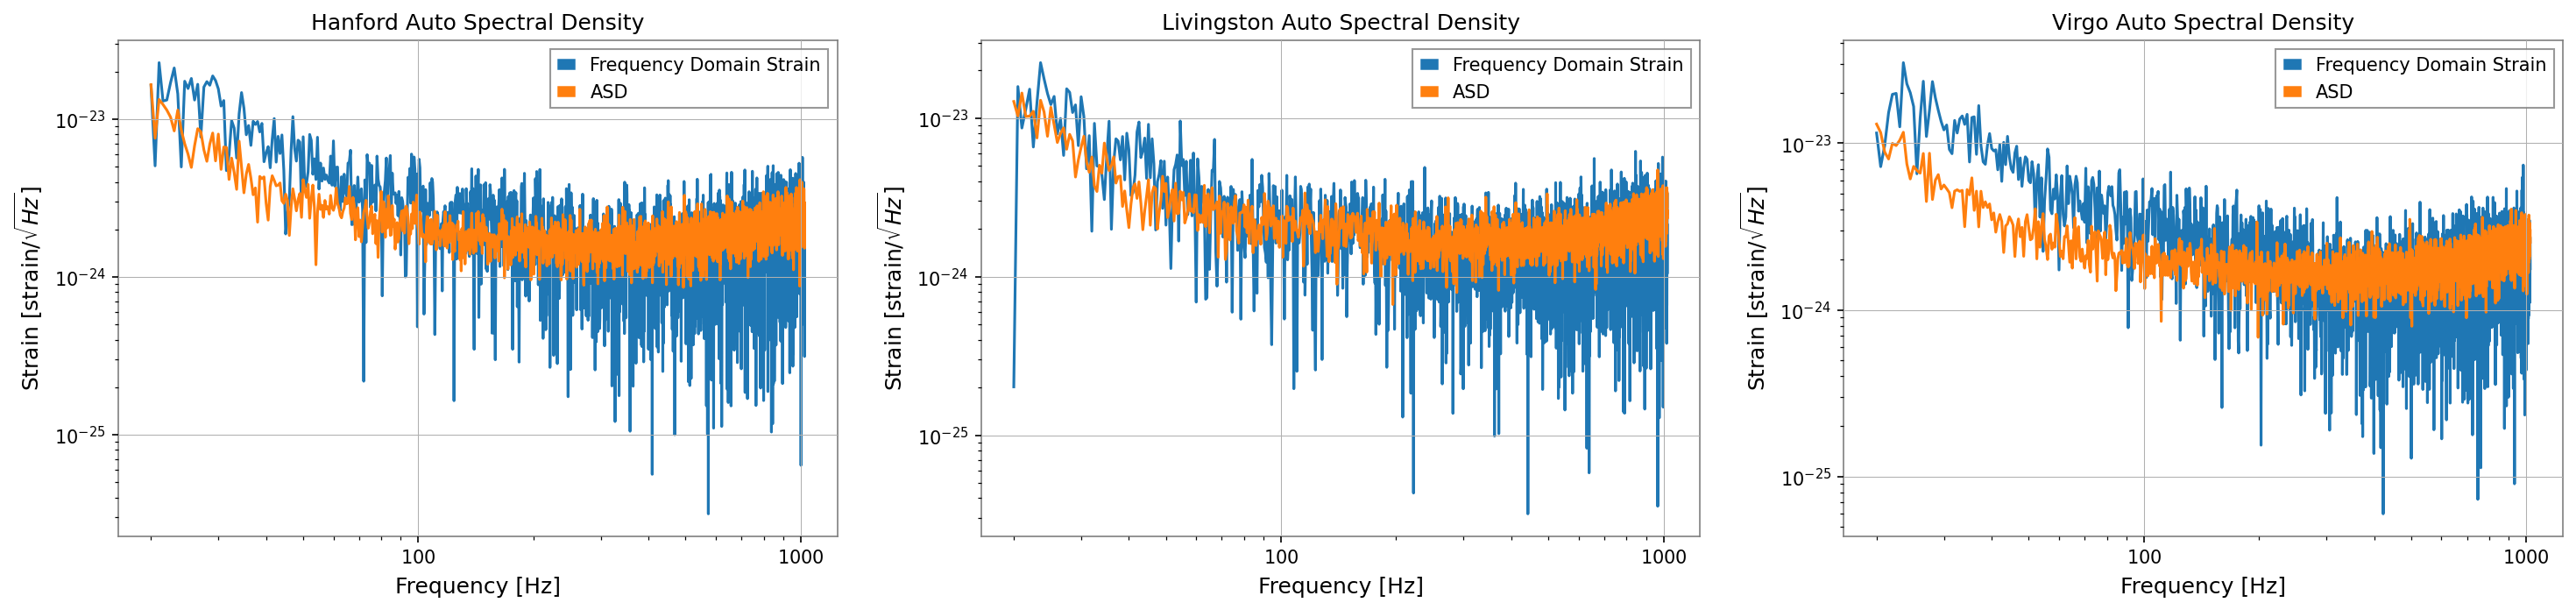

In [46]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=L1_psd.frequencies.value, psd_array=L1_psd.value)
V1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=V1_psd.frequencies.value, psd_array=V1_psd.value)
H1.maximum_frequency = 1024
L1.maximum_frequency = 1024
V1.maximum_frequency = 1024

fig, ax = plt.subplots(1, 3, figsize = (24,5), dpi = 150)
h1_idxs = H1.strain_data.frequency_mask
l1_idxs = L1.strain_data.frequency_mask
v1_idxs = V1.strain_data.frequency_mask
ax[0].loglog(H1.strain_data.frequency_array[h1_idxs],
          np.abs(H1.strain_data.frequency_domain_strain[h1_idxs]), label = 'Frequency Domain Strain')
ax[0].loglog(H1.power_spectral_density.frequency_array[h1_idxs],
          H1.power_spectral_density.asd_array[h1_idxs], label = 'ASD')
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax[0].set_title("Hanford Auto Spectral Density")

ax[1].loglog(L1.strain_data.frequency_array[l1_idxs],
          np.abs(L1.strain_data.frequency_domain_strain[l1_idxs]), label = 'Frequency Domain Strain')
ax[1].loglog(L1.power_spectral_density.frequency_array[l1_idxs],
          L1.power_spectral_density.asd_array[l1_idxs], label = 'ASD')
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax[1].set_title("Livingston Auto Spectral Density")

ax[2].loglog(V1.strain_data.frequency_array[v1_idxs],
          np.abs(V1.strain_data.frequency_domain_strain[v1_idxs]), label = 'Frequency Domain Strain')
ax[2].loglog(V1.power_spectral_density.frequency_array[v1_idxs],
          V1.power_spectral_density.asd_array[v1_idxs], label = 'ASD')
ax[2].legend()
ax[2].set_xlabel("Frequency [Hz]")
ax[2].set_ylabel("Strain [strain/$\sqrt{Hz}$]")
ax[2].set_title("Virgo Auto Spectral Density")
plt.show()

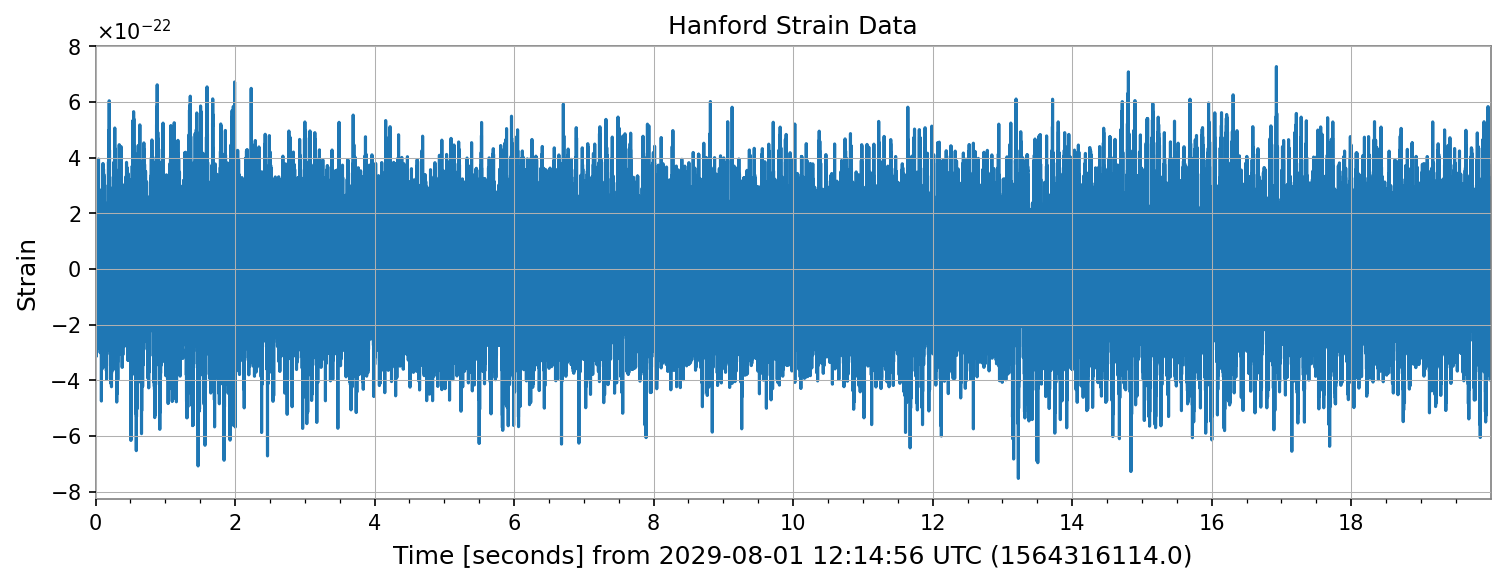

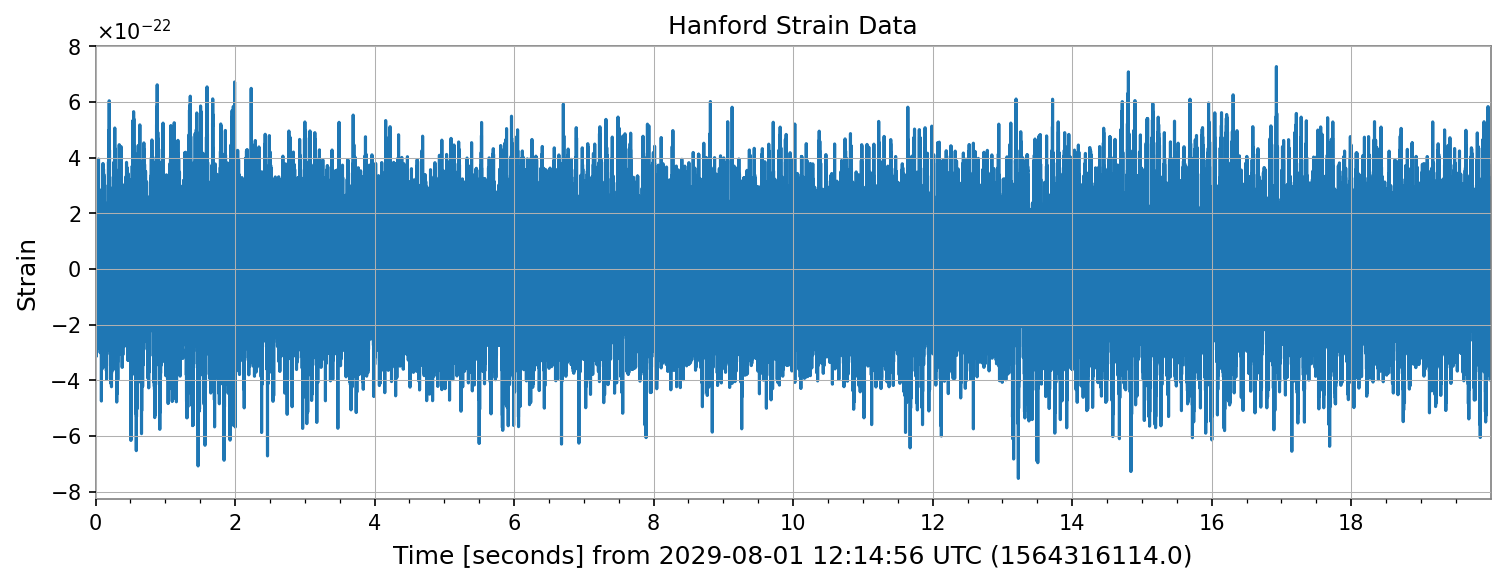

In [52]:
H1_data.plot(title = 'Hanford Strain Data', ylabel = 'Strain', dpi = 150)

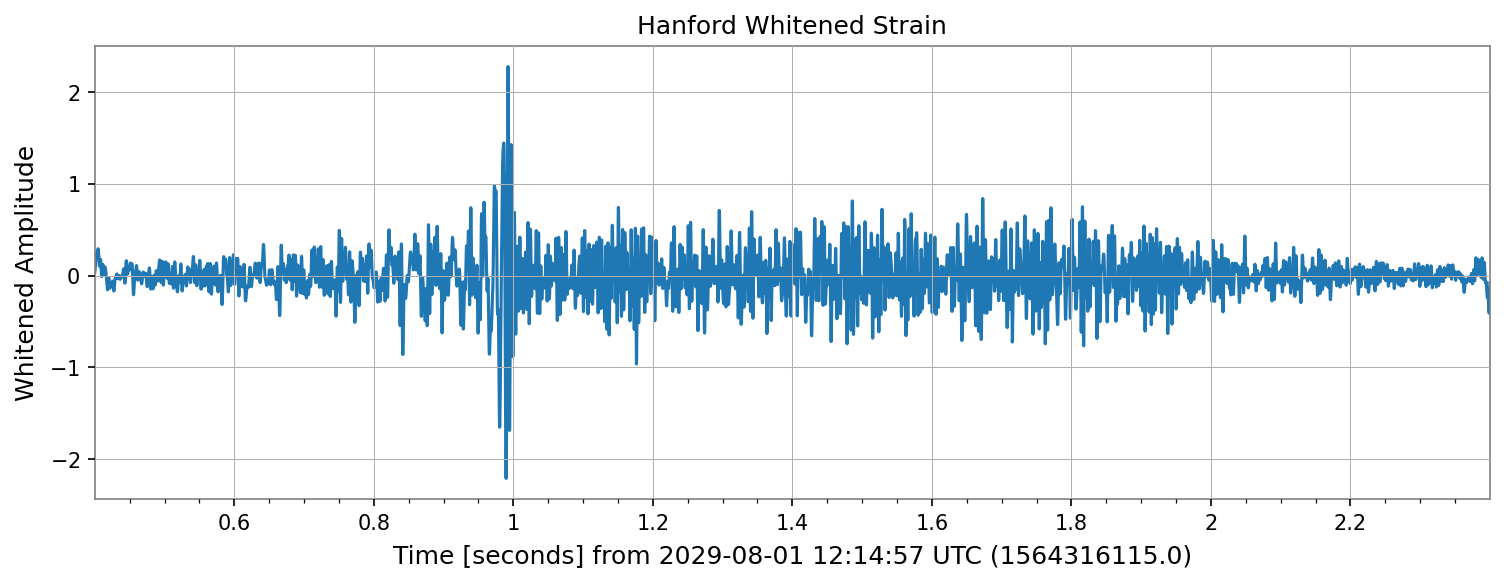

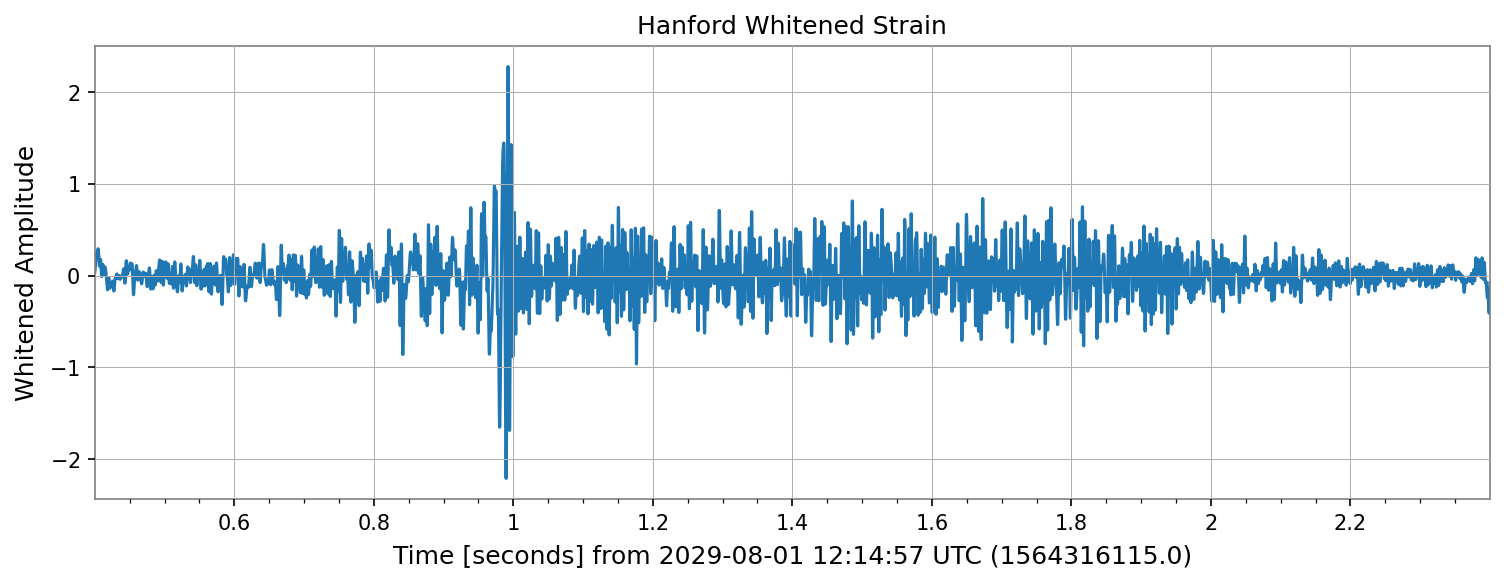

In [54]:
H1_whiten = H1_data_clip.whiten(fftlength=duration, overlap=0, method='median', window='hanning', detrend='constant')
H1_wb = H1_whiten.bandpass(20,350)
H1_wb.plot(title = "Hanford Whitened Strain", ylabel = 'Whitened Amplitude', dpi = 150)

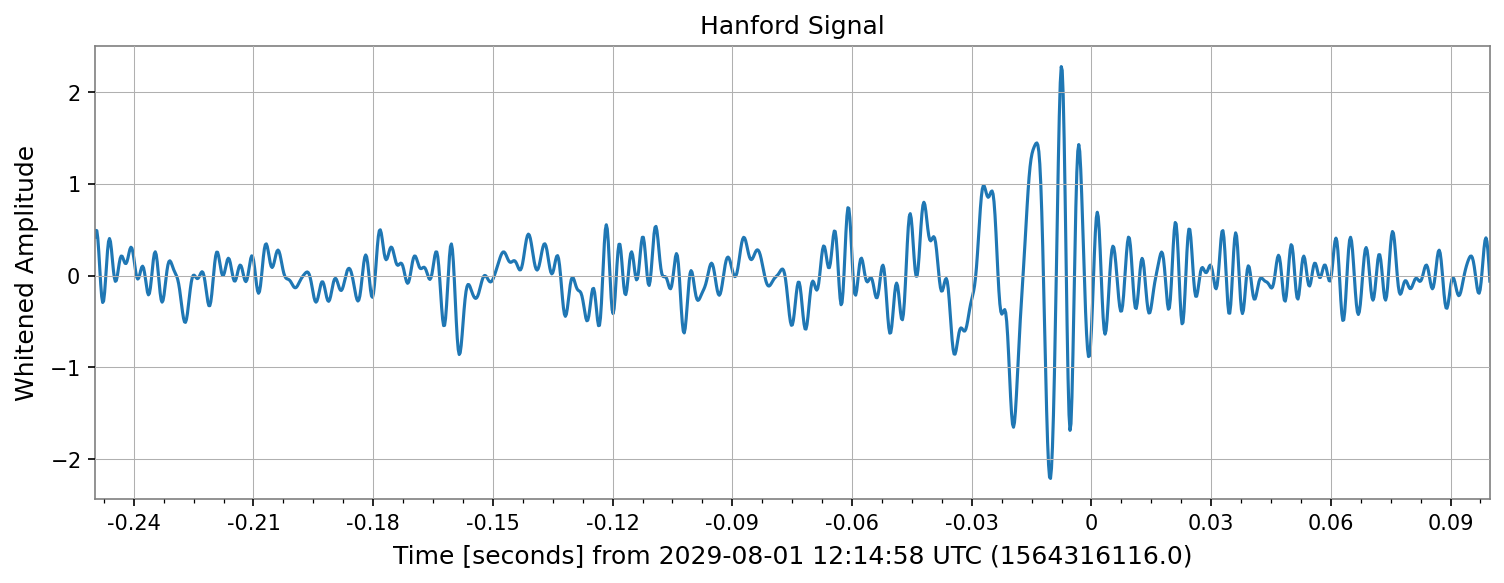

In [56]:
H1_signal = H1_wb[((H1_wb.times - 1564316115*u.s) > 0.75*u.s) & ((H1_wb.times - 1564316115*u.s) < 1.1*u.s)]
H1_signal.plot(title = 'Hanford Signal', ylabel = 'Whitened Amplitude', dpi = 150)
H1_ct = H1_signal.times[np.argmax(H1_signal)]

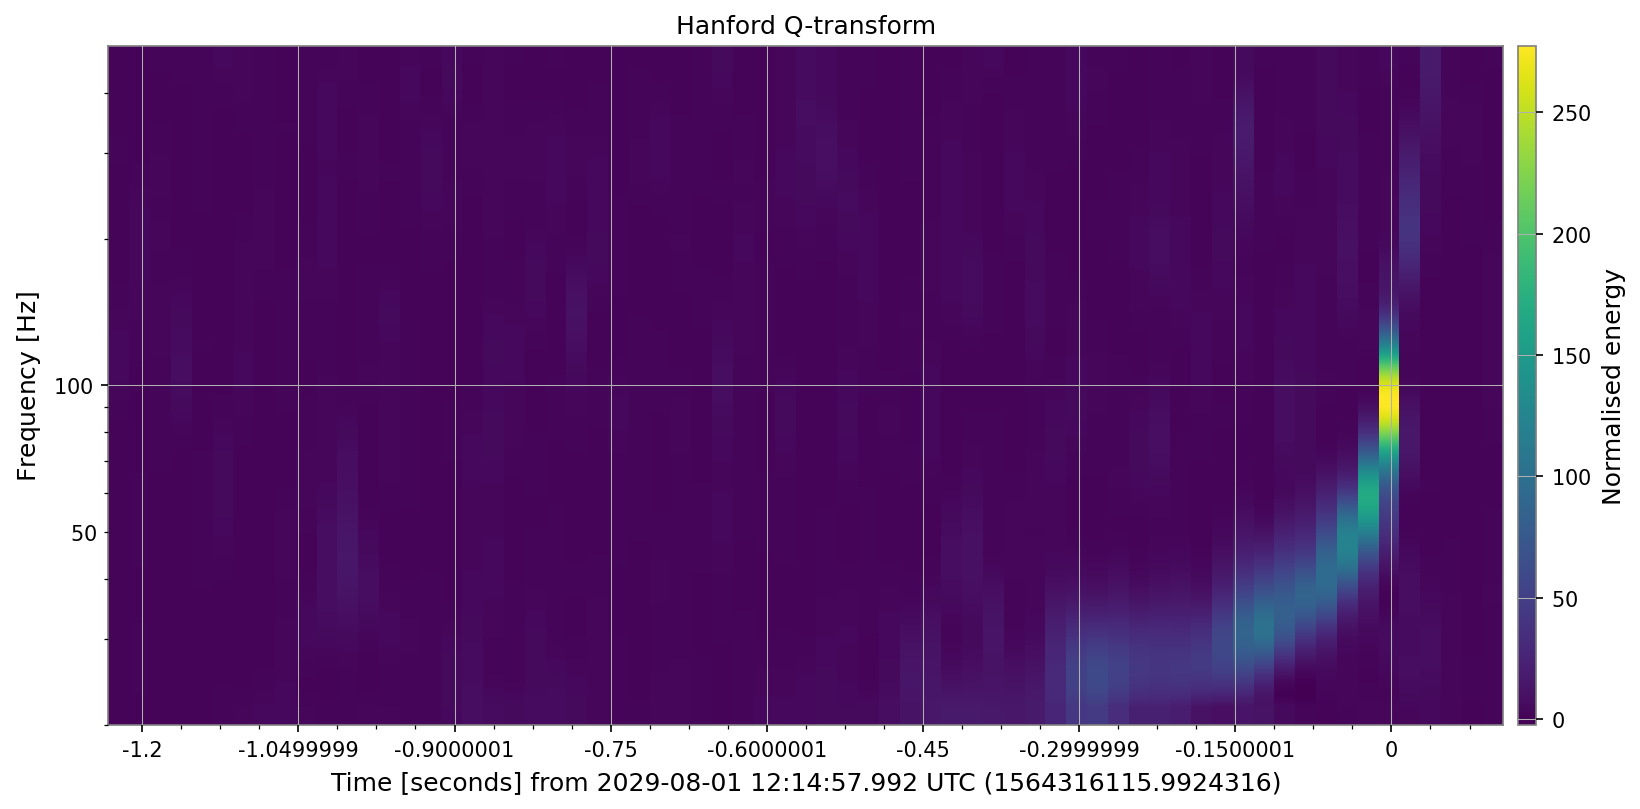

In [59]:
hgps = H1_ct
H1_q = H1_data.q_transform(frange=(20,500), fres = 0.05)
H1_q_clip_plot = H1_q[(H1_q.times>hgps - 1.25*u.s) & (H1_q.times<hgps+0.1*u.s)]
H1_q_clip = H1_q[(H1_q.times>hgps - 0.10*u.s) & (H1_q.times<hgps+0.001*u.s)]
plot = H1_q_clip_plot.plot(cmap = 'viridis', dpi = 150)
ax = plot.gca()
ax.set_title('Hanford Q-transform')
ax.set_epoch(hgps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

In [60]:
hf_idxs = [np.argmax(f) for f in H1_q_clip]
H1_signalf = H1_q_clip.frequencies[hf_idxs].value

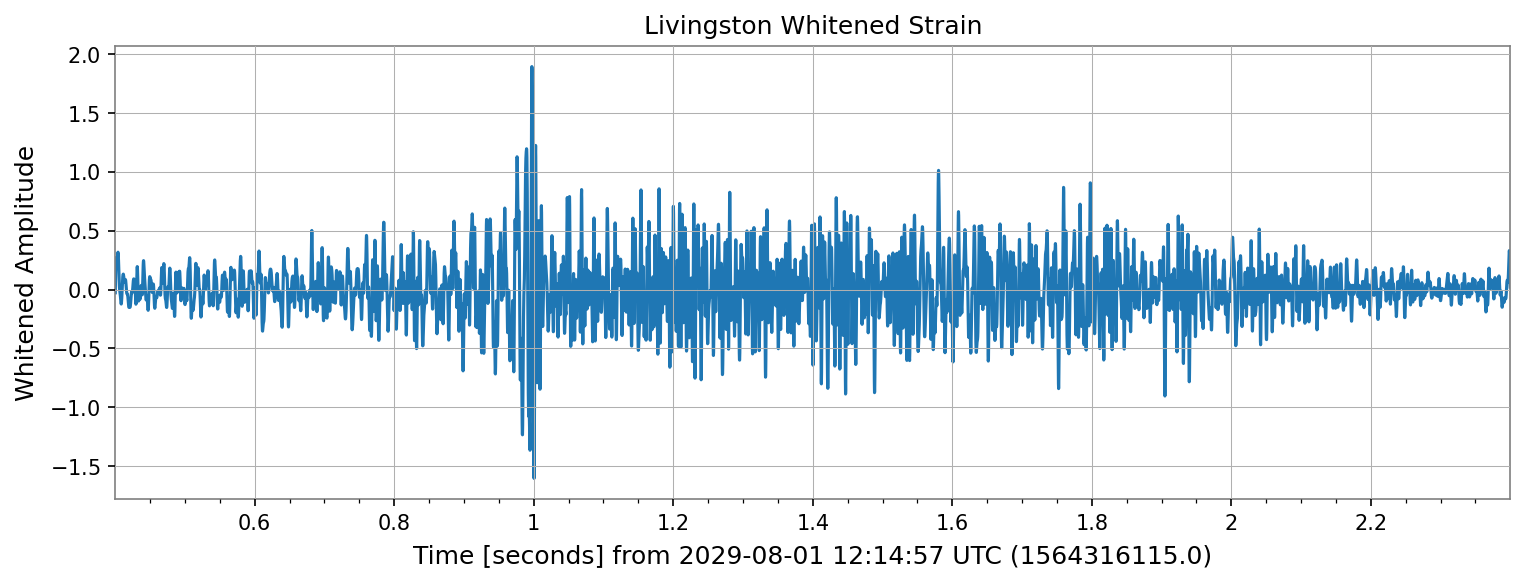

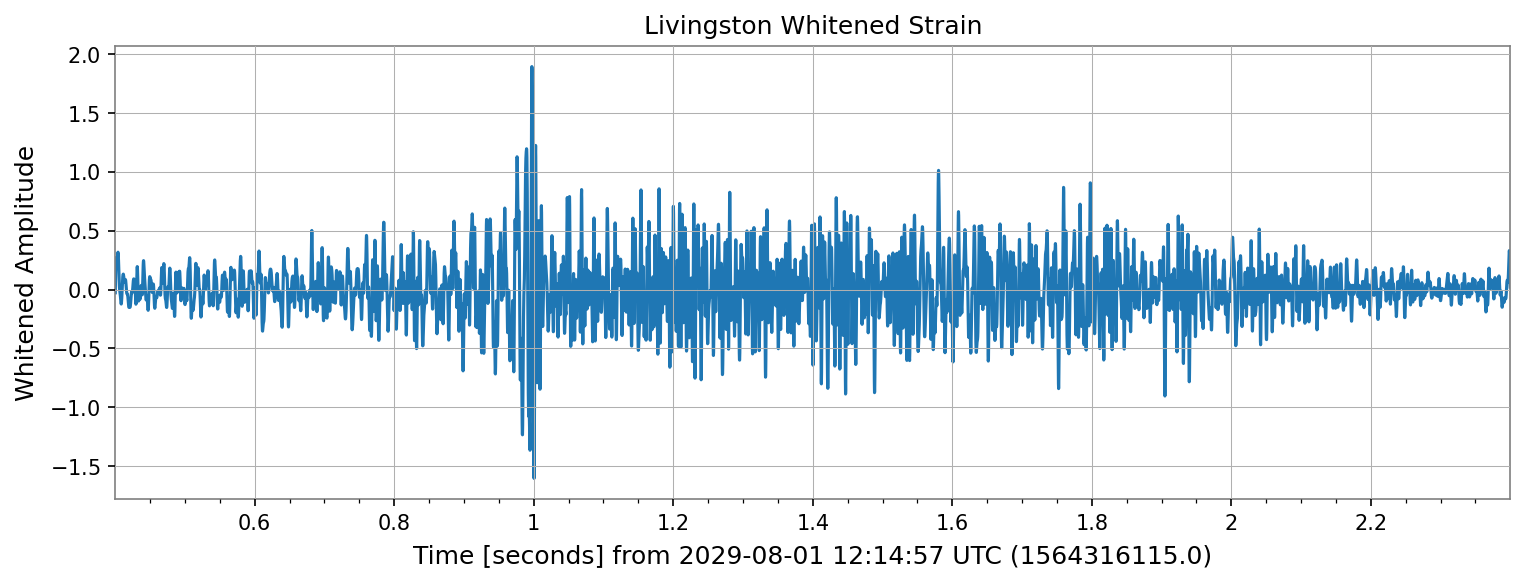

In [61]:
L1_whiten = L1_data_clip.whiten(fftlength=duration, overlap=0, method='median', window='hanning', detrend='constant')
L1_wb = L1_whiten.bandpass(30,350)
L1_wb.plot(title = "Livingston Whitened Strain", ylabel = 'Whitened Amplitude', dpi = 150)

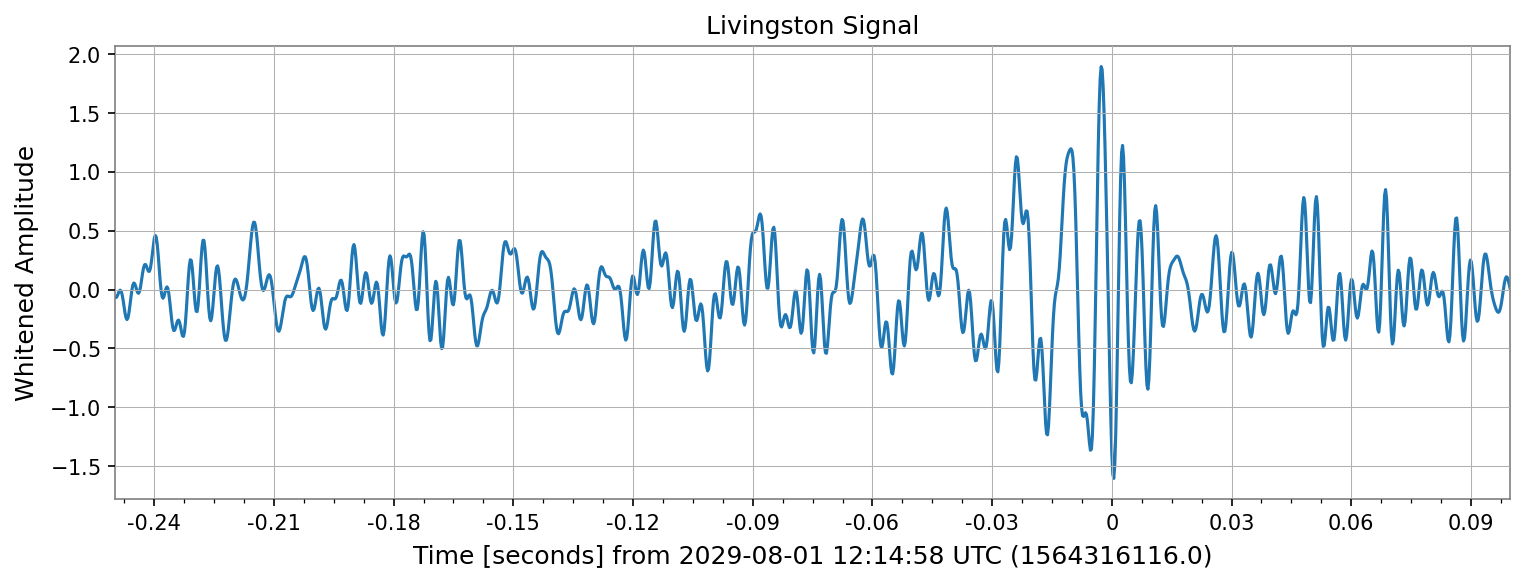

In [62]:
L1_signal = L1_wb[((L1_wb.times - 1564316115*u.s) > 0.75*u.s) & ((L1_wb.times - 1564316115*u.s) < 1.1*u.s)]
L1_signal.plot(title = "Livingston Signal", ylabel = 'Whitened Amplitude', dpi = 150)
L1_ct = L1_signal.times[np.argmax(L1_signal)]

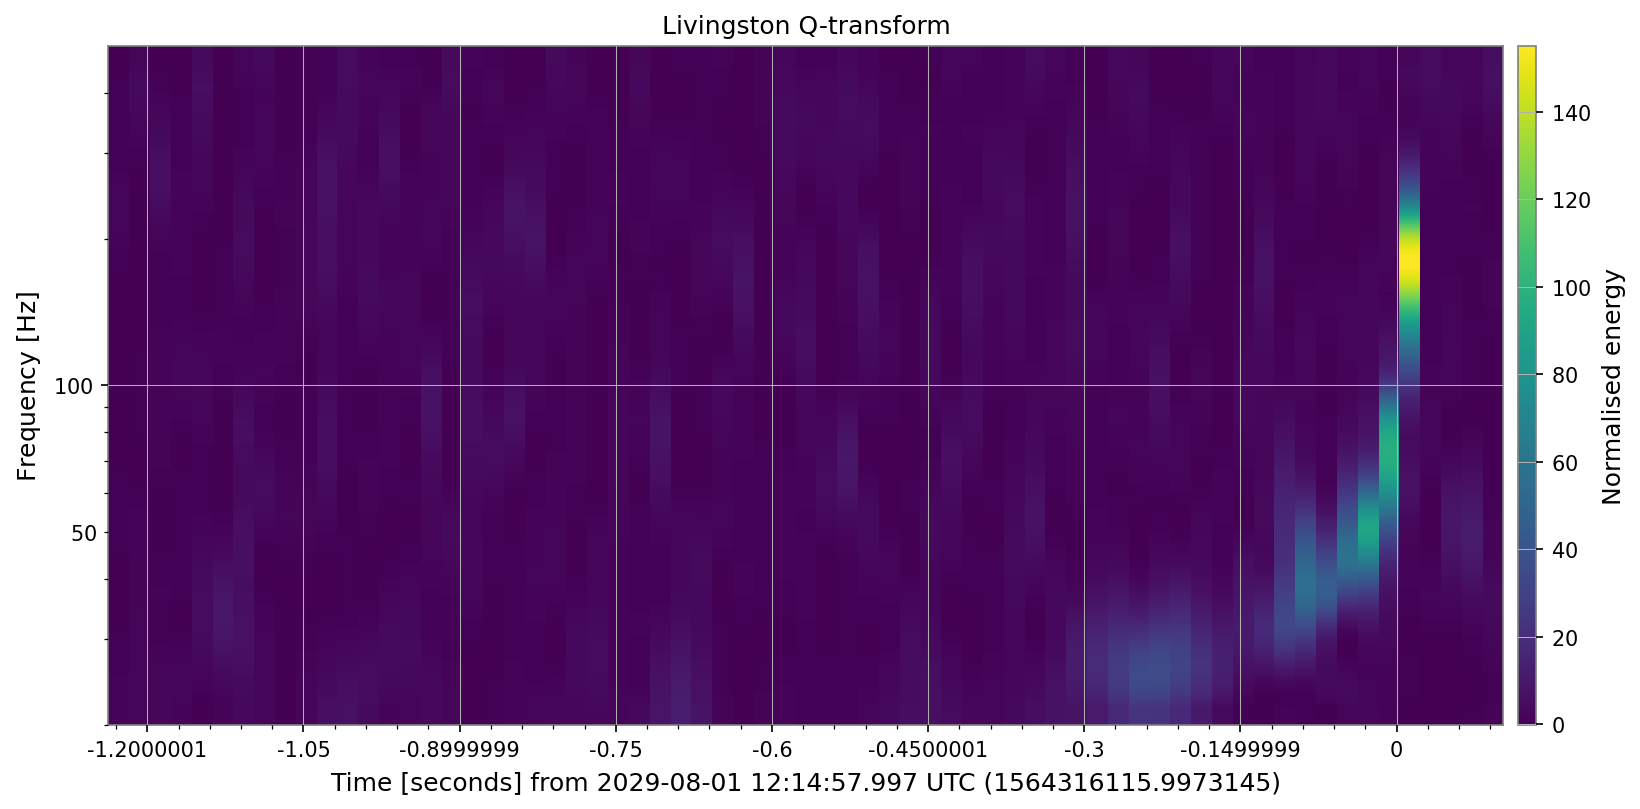

In [63]:
lgps = L1_ct
L1_q = L1_data.q_transform(frange=(20,500), fres = 0.05)
L1_q_clip_plot = L1_q[(L1_q.times>lgps - 1.25*u.s) & (L1_q.times<lgps+0.1*u.s)]
L1_q_clip = L1_q[(L1_q.times>lgps - 0.08*u.s) & (L1_q.times<lgps+0.0*u.s)]
plot = L1_q_clip_plot.plot(cmap = 'viridis', dpi = 150)
ax = plot.gca()
ax.set_title('Livingston Q-transform')
ax.set_epoch(lgps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

In [64]:
lf_idxs = [np.argmax(f) for f in L1_q_clip]
L1_signalf = L1_q_clip.frequencies[lf_idxs].value

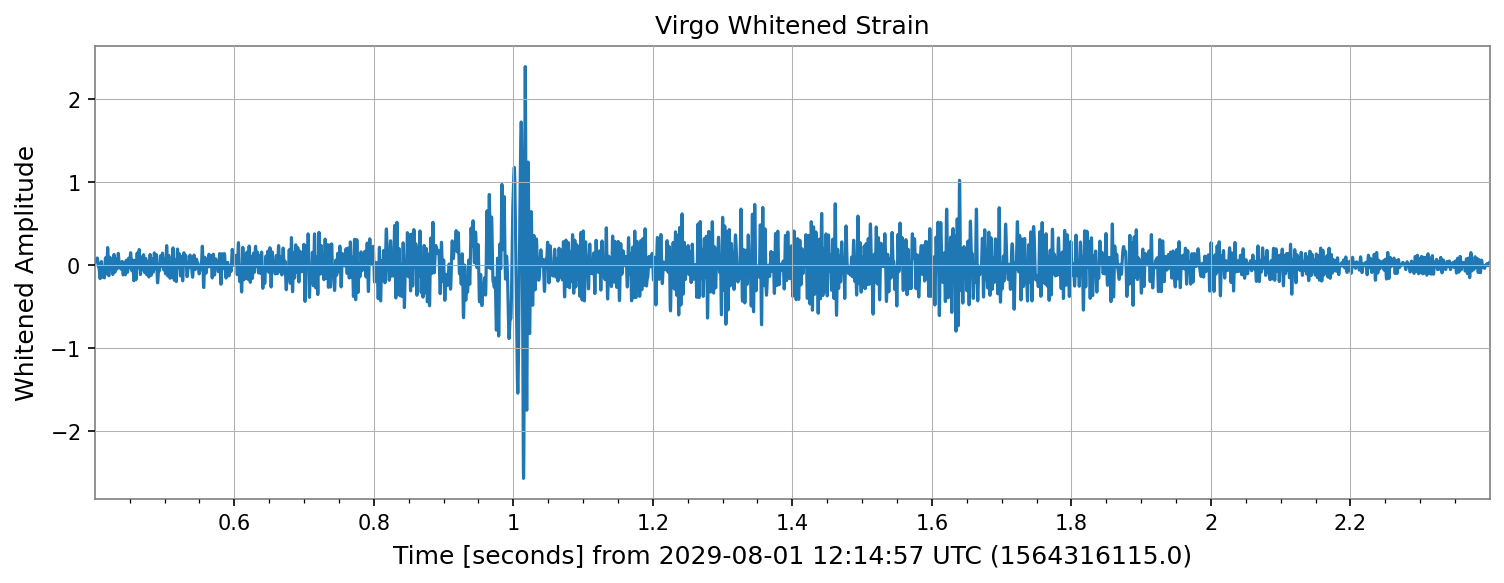

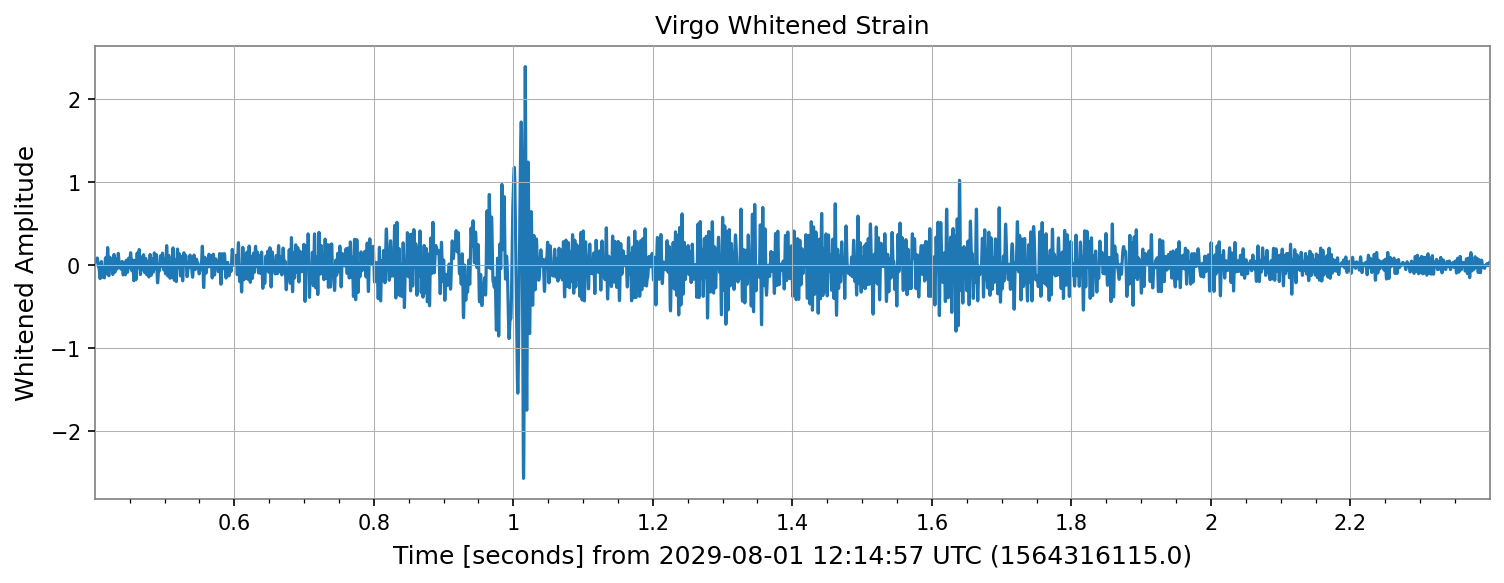

In [65]:
V1_whiten = (V1_data_clip/u.ct).whiten(fftlength=duration, overlap=0, method='median', window='hanning', detrend='constant')
V1_wb = V1_whiten.bandpass(30,350)
V1_wb.plot(title = "Virgo Whitened Strain", ylabel = 'Whitened Amplitude', dpi = 150)

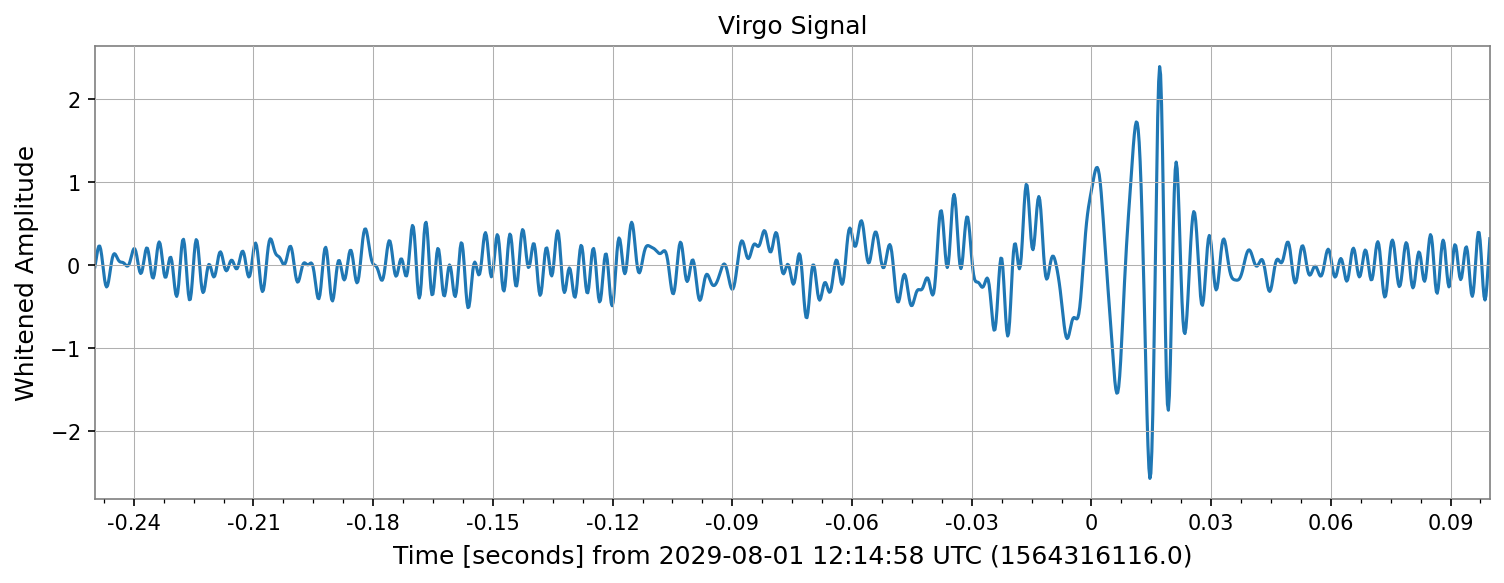

In [66]:
V1_signal = V1_wb[((V1_wb.times - 1564316115*u.s) > 0.75*u.s) & ((V1_wb.times - 1564316115*u.s) < 1.1*u.s)]
V1_signal.plot(title = "Virgo Signal", ylabel = 'Whitened Amplitude', dpi = 150)
V1_ct = V1_signal.times[np.argmax(V1_signal)]

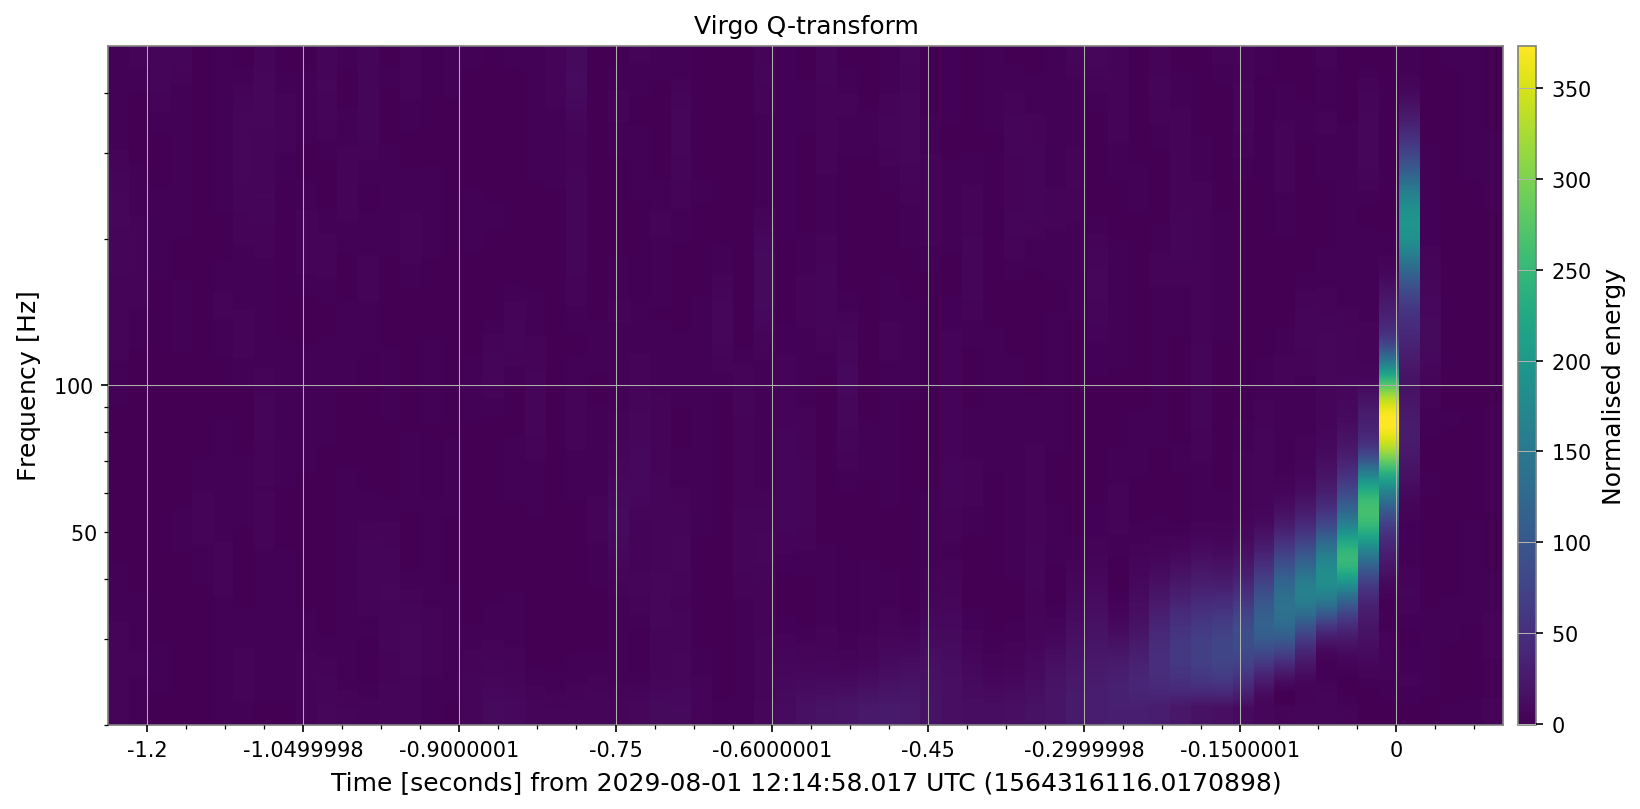

In [68]:
vgps = V1_ct
V1_q = V1_data.q_transform(frange=(20,500), fres = 0.05)
V1_q_clip_plot = V1_q[(V1_q.times>vgps - 1.25*u.s) & (V1_q.times<vgps+0.1*u.s)]
V1_q_clip = V1_q[(V1_q.times>vgps - 0.12*u.s) & (V1_q.times<vgps+0.0*u.s)]
plot = V1_q_clip_plot.plot(cmap = 'viridis', dpi = 150)
ax = plot.gca()
ax.set_title('Virgo Q-transform')
ax.set_epoch(vgps)
ax.set_yscale('log')
ax.colorbar(label="Normalised energy")

In [69]:
vf_idxs = [np.argmax(f) for f in V1_q_clip]
V1_signalf = V1_q_clip.frequencies[vf_idxs].value

In [70]:
times = np.hstack((hgps.value - H1_q_clip.times.value, lgps.value - L1_q_clip.times.value, vgps.value - V1_q_clip.times.value))
signal_frequencies = np.hstack((H1_signalf, L1_signalf, V1_signalf))

Text(0, 0.5, 'Frequency')

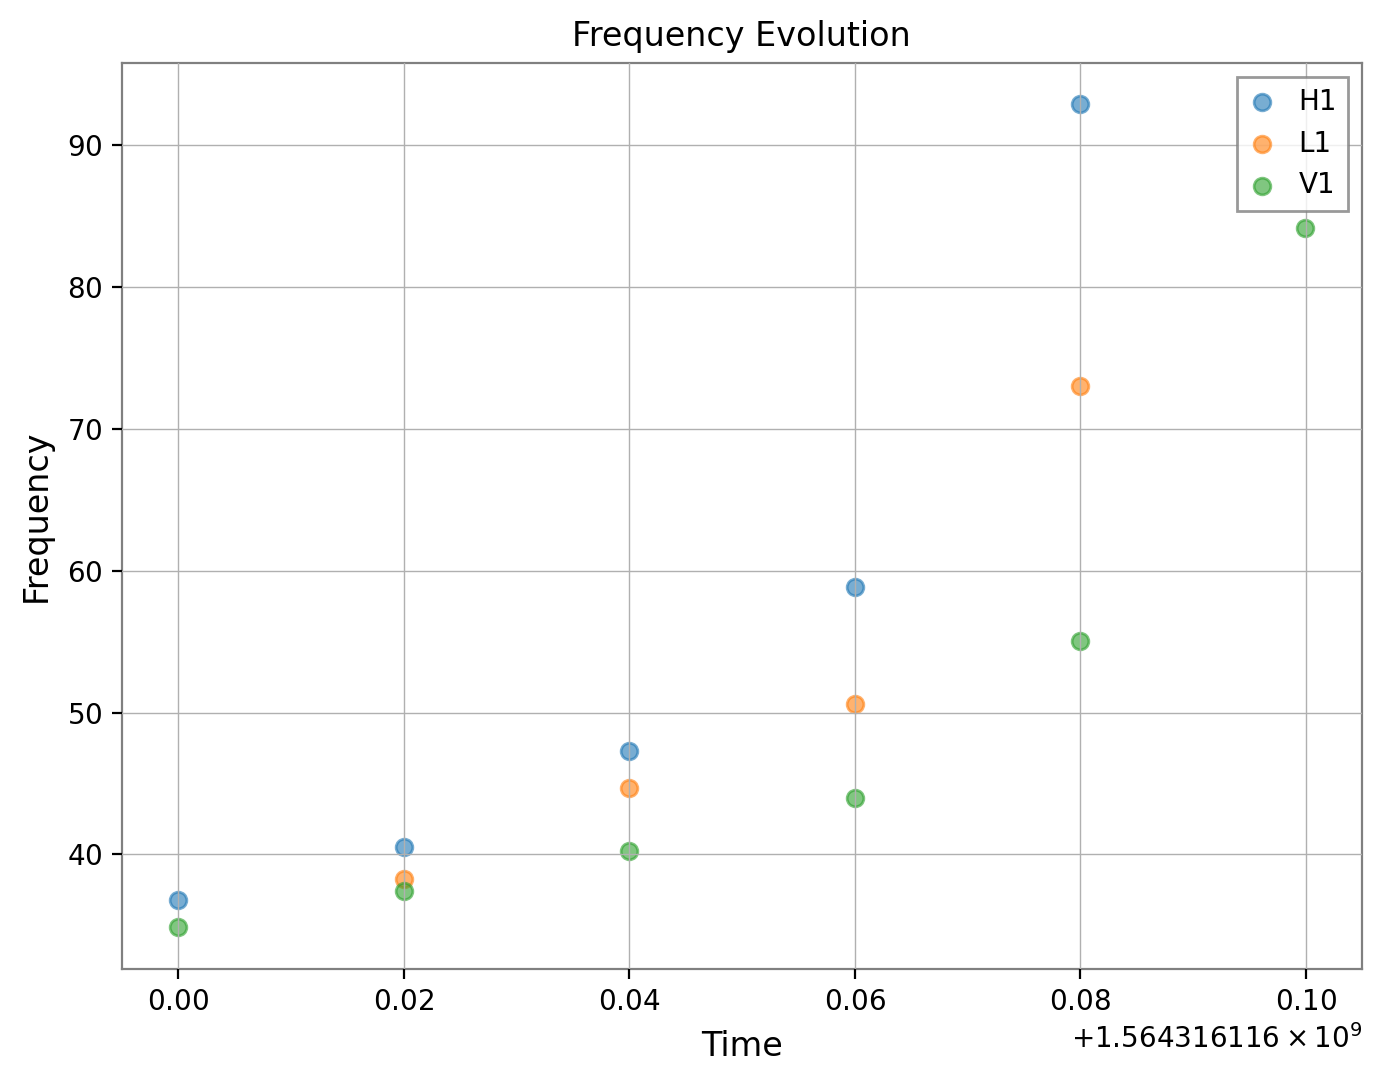

In [71]:
plt.figure(figsize = (8,6), dpi = 200)
plt.scatter(H1_q_clip.times.value, H1_signalf, label = "H1", alpha = 0.6)
plt.scatter(L1_q_clip.times.value, L1_signalf, label = "L1", alpha = 0.6)
plt.scatter(V1_q_clip.times.value, V1_signalf, label = "V1", alpha = 0.6)
plt.legend()
plt.title('Frequency Evolution')
plt.xlabel('Time')
plt.ylabel('Frequency')

Text(0, 0.5, '$f^{-8/3}$')

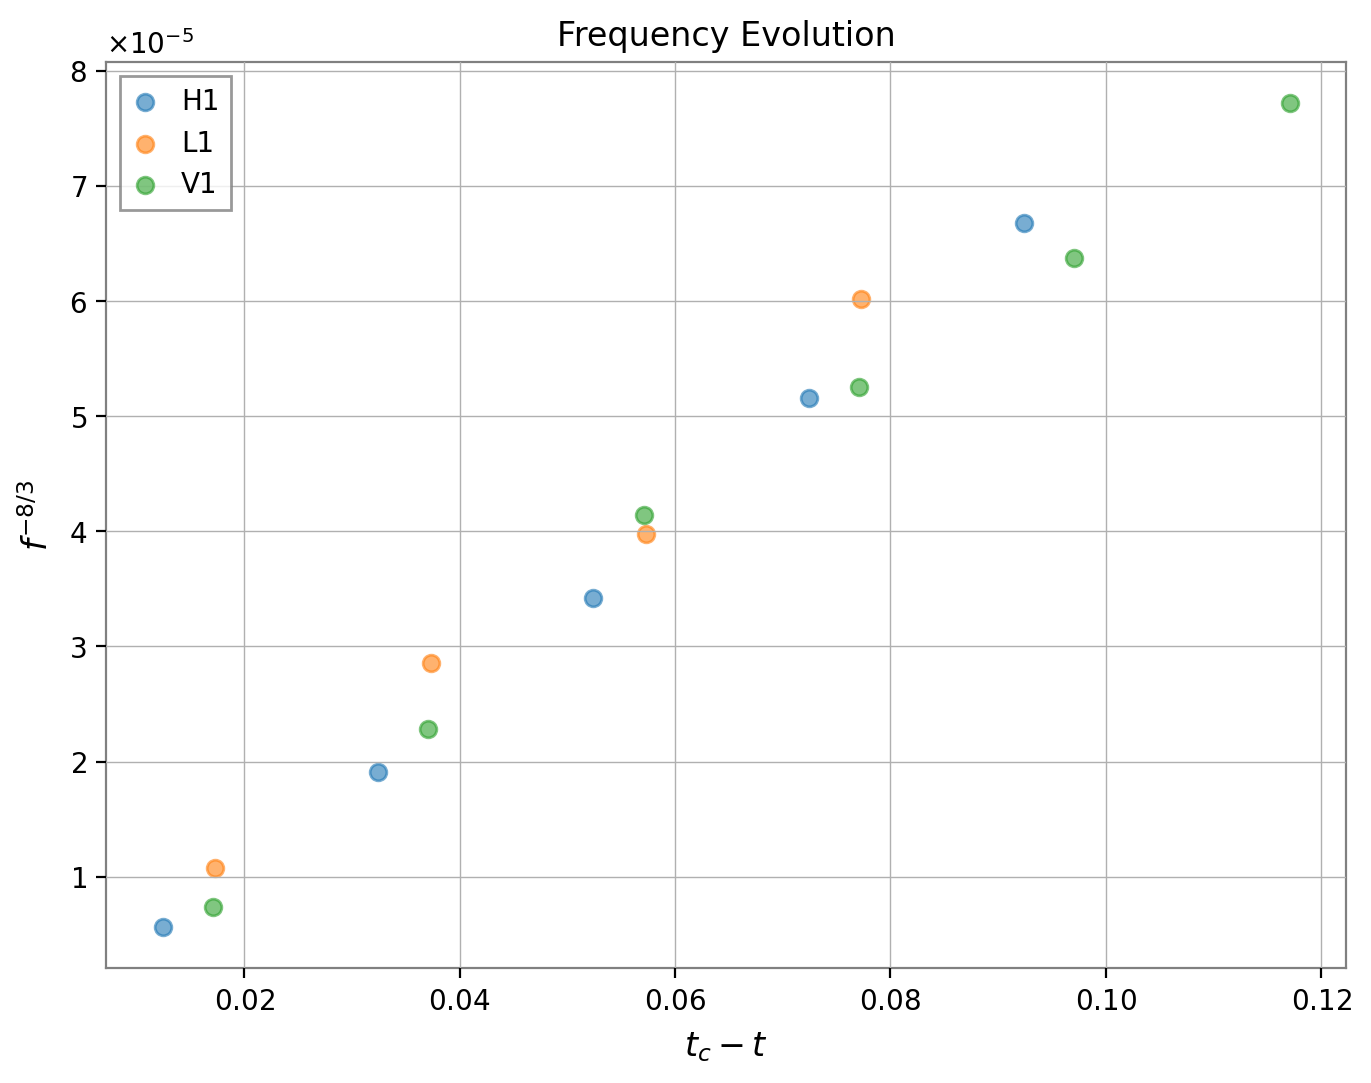

In [72]:
plt.figure(figsize = (8,6), dpi = 200)
plt.scatter(hgps.value - H1_q_clip.times.value, H1_signalf**(-8/3), label = "H1", alpha = 0.6)
plt.scatter(lgps.value - L1_q_clip.times.value, L1_signalf**(-8/3), label = "L1", alpha = 0.6)
plt.scatter(vgps.value - V1_q_clip.times.value, V1_signalf**(-8/3), label = "V1", alpha = 0.6)
plt.legend()
plt.title('Frequency Evolution')
plt.xlabel('$t_c - t$')
plt.ylabel('$f^{-8/3}$')

In [73]:
slope, _ , _, _, _ = linregress(times, signal_frequencies**(-8/3))
M = ((slope*((8*np.pi)**(8/3)/5)**(-1))**(3/5))*const.c**3/const.G*1*u.s
M.to(u.M_sun)

<Quantity 39.72996461 solMass>

In [74]:
l1copy = L1_signal.copy()
v1copy = V1_signal.copy()

In [75]:
H1_signal.times[np.argmax(H1_signal)] - L1_signal.times[np.argmax(L1_signal)], H1_signal.times[np.argmax(H1_signal)] - V1_signal.times[np.argmax(V1_signal)]

(<Quantity -0.00488281 s>, <Quantity -0.0246582 s>)

In [76]:
l1copy.times = l1copy.times + H1_signal.times[np.argmax(H1_signal)] - L1_signal.times[np.argmax(L1_signal)]
v1copy.times = v1copy.times + H1_signal.times[np.argmax(H1_signal)] - V1_signal.times[np.argmax(V1_signal)]

Text(0, 0.5, 'Whitened Amplitude')

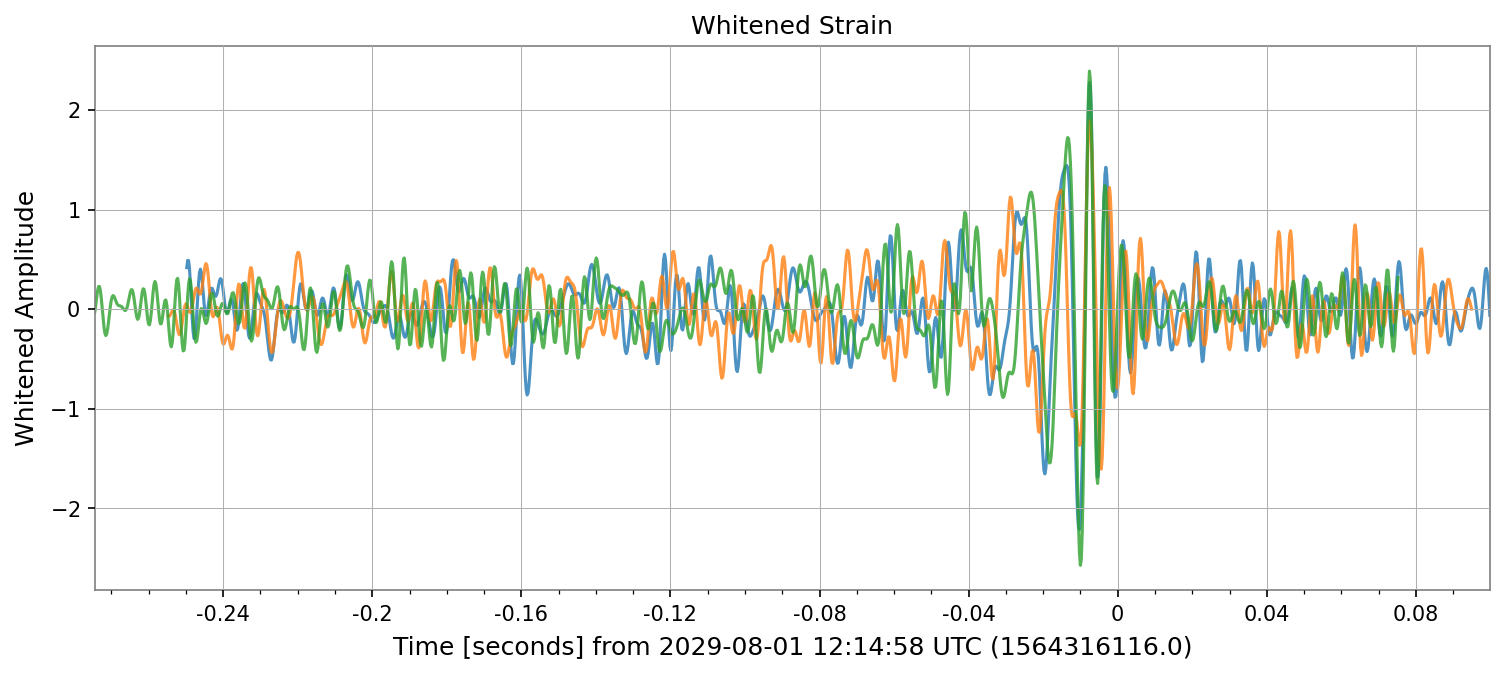

In [79]:
plot = Plot(H1_signal, l1copy, v1copy, figsize = (12,4.8), alpha = 0.8, dpi = 150)
plt.title("Whitened Strain")
plt.ylabel('Whitened Amplitude')

Text(0, 0.5, 'Whitened Amplitude')

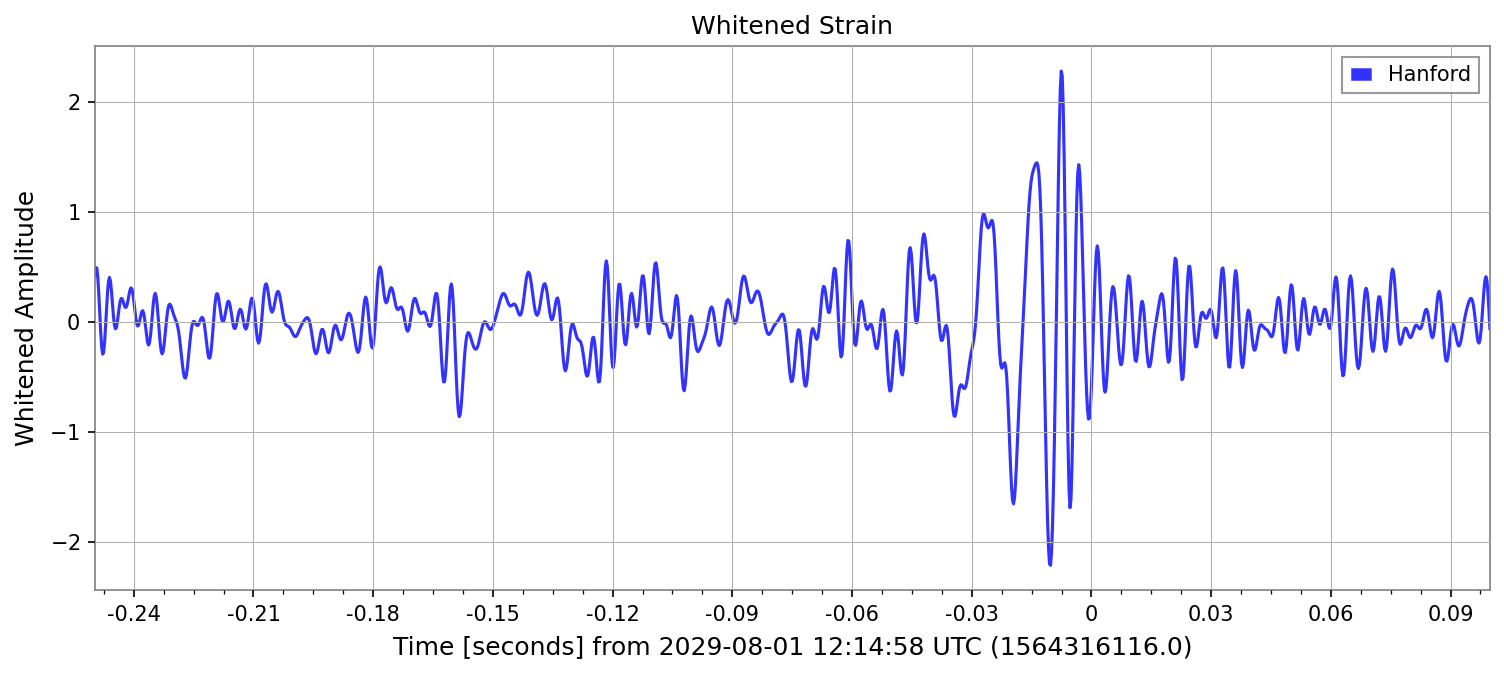

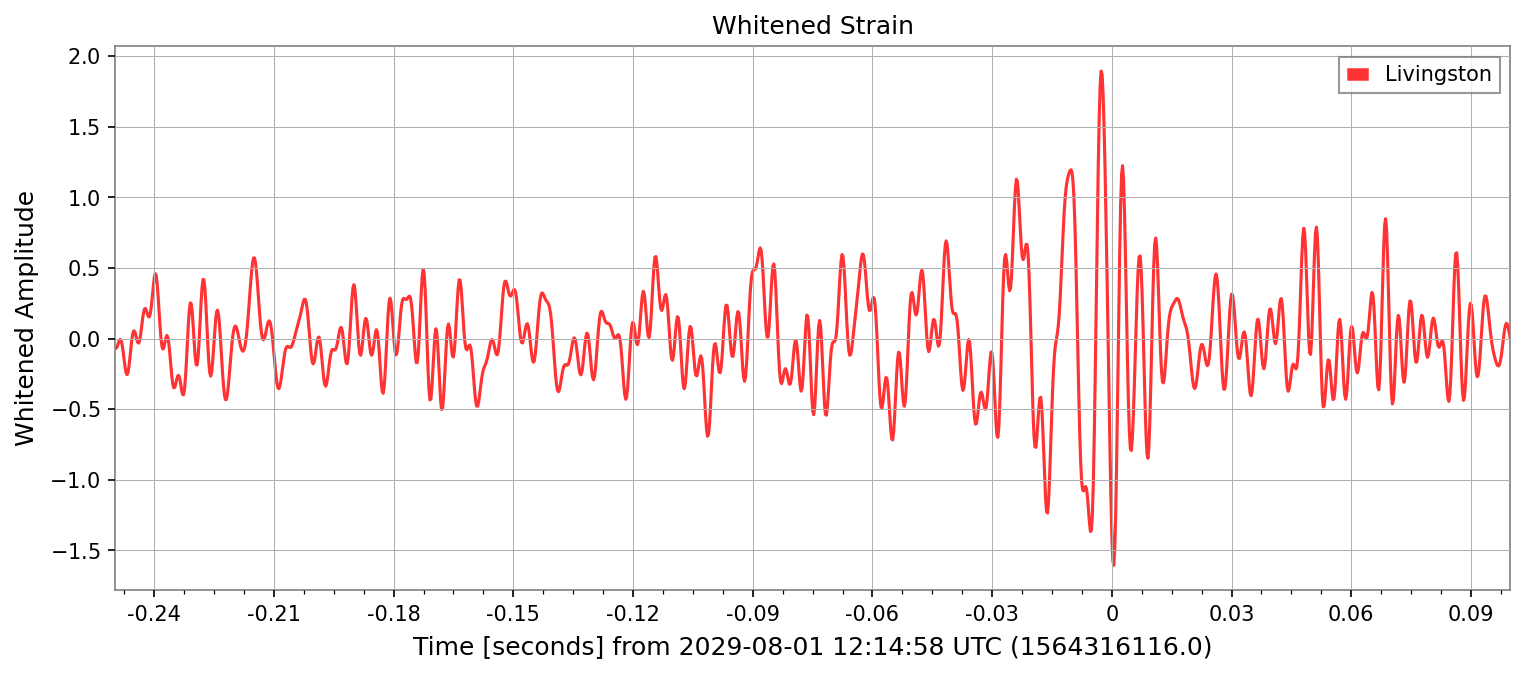

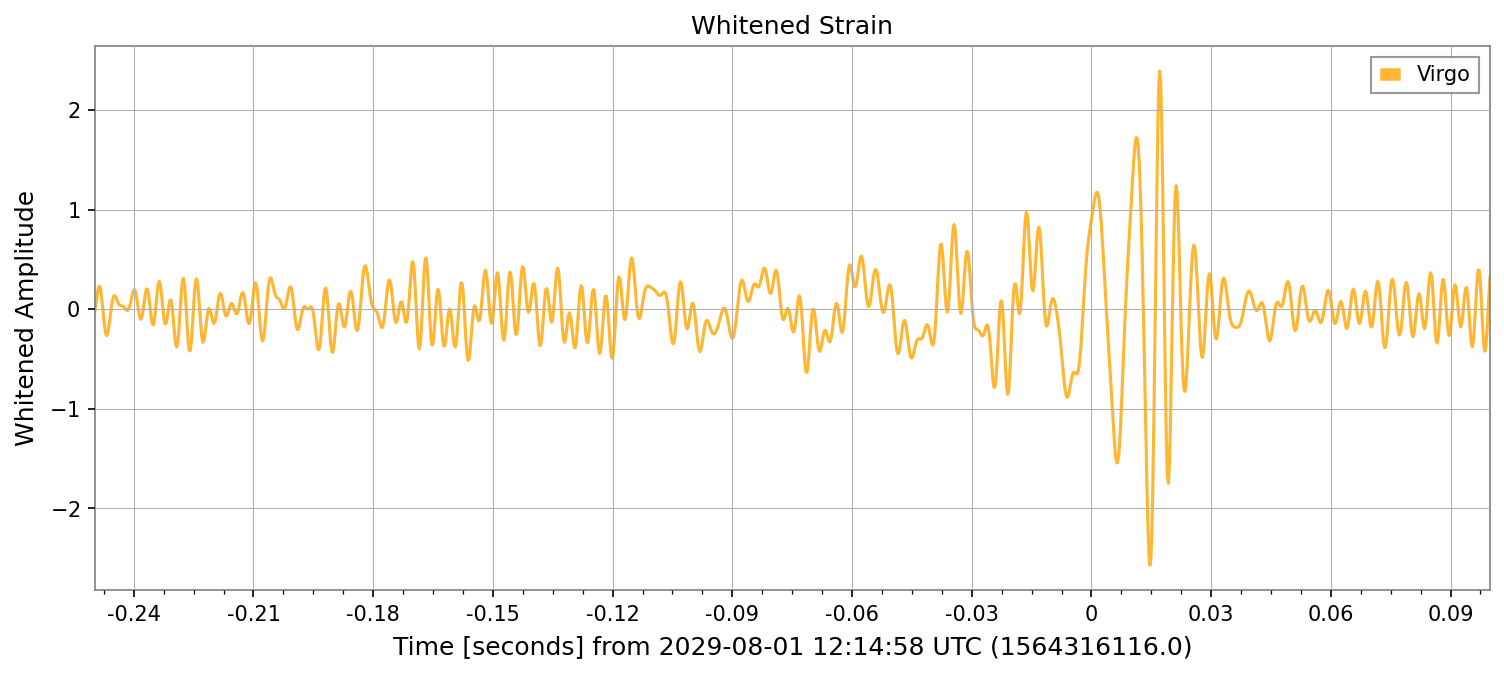

In [80]:
plot = Plot(H1_signal, figsize = (12,4.8), alpha = 0.8, label = 'Hanford', color = 'blue', dpi = 150)
plt.legend()
plt.title("Whitened Strain")
plt.ylabel('Whitened Amplitude')
plot = Plot(L1_signal, figsize=(12, 4.8), alpha = 0.8, label = 'Livingston', color = 'red', dpi = 150)
plt.legend()
plt.title("Whitened Strain")
plt.ylabel('Whitened Amplitude')
plot = Plot(V1_signal, figsize=(12, 4.8), alpha = 0.8, label = 'Virgo', color = 'orange', dpi = 150)
plot.show()
plt.legend()
plt.title("Whitened Strain")
plt.ylabel('Whitened Amplitude')

In [81]:
#https://iopscience.iop.org/article/10.3847/1538-4365/ab06fc/pdf
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30, maximum=40)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.8, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0.0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=t_c-0.65, maximum=t_c+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  0.111
prior['ra'] =  5.553
prior['theta_jn'] =  bilby.core.prior.Sine(name = 'inclination_angle', minimum = 0.0, maximum = np.pi, latex_label = '$\iota$')
prior['psi'] =  Uniform(name="polarisation_angle", minimum=0.0, maximum=np.pi, latex_label = '$\psi$')
prior['luminosity_distance'] = bilby.core.prior.PowerLaw(alpha = 2., minimum = 500, maximum = 2000., name = 'luminosity_distance')

In [82]:
interferometers = [H1, L1, V1]
#EOBNRv2, IMRPhenomPv2, SEOBNRv4, TaylorT1
waveform_arguments = dict(waveform_approximant = 'IMRPhenomD', reference_frequency = 100, minimum_frequency = 20, catch_waveform_errors = True)
waveform_generator = bilby.gw.WaveformGenerator(frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                waveform_arguments = waveform_arguments, 
                                                parameter_conversion = convert_to_lal_binary_black_hole_parameters)
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(interferometers, waveform_generator, priors = prior, time_marginalization = True,
                                                            phase_marginalization = True, distance_marginalization = False)

13:45 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [83]:
result = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short_run_39', label="GW290801",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="rwalk", nact = 10, walks = 10, nlive=1000, dlogz=3, npool = 4)

13:45 bilby INFO    : Running for label 'GW290801', output will be saved to 'short_run_39'
13:45 bilby INFO    : Using lal version 7.1.7
13:45 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v7.5;Id: bd2ad8ca448e9761e3010e519a656789332ea28a;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
13:45 bilby INFO    : Using lalsimulation version 3.1.2
13:45 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v7.5;Id: bd2ad8ca448e9761e3010e519a656789332ea28a;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
13:45 bilby INFO    : Search parameters:
13:45 bilby INFO    :   chirp_mass = Uniform(minimum=30, maximum=40, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
13:45 bilby INFO    :   mass_ratio = Uniform(minimum=0.8, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
13:45 bilby INFO    :   theta_jn = Sine(minimum=0.0, maximum=3.141592653589793, name=

0it [00:00, ?it/s]

13:45 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 1000, 'first_update': None, 'walks': 10, 'npdim': None, 'rstate': None, 'queue_size': 4, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f82902591d0>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 10, 'print_method': 'tqdm'}
13:45 bilby INFO    : Checkpoint every check_point_delta_t = 600s
13:45 bilby INFO    : Using dynesty version 1.0.1
13:45 bilby INFO    : Using the bilb

14:39 bilby INFO    : Sampling time: 0:52:30.890557
/usr/local/lib/python3.7/dist-packages/bilby/core/result.py:1453: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if "npool" in inspect.getargspec(conversion_function).args:
14:39 bilby INFO    : Reconstructing marginalised parameters.
14:39 bilby INFO    : Using a pool with size 4 for nsamples=16793


  0%|          | 0/16793 [00:00<?, ?it/s]

14:53 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/16793 [00:00<?, ?it/s]

14:53 bilby INFO    : Computing SNRs for every sample.
14:53 bilby INFO    : Using a pool with size 4 for nsamples=16793


  0%|          | 0/16793 [00:00<?, ?it/s]

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f82874e7520>
14:55 bilby INFO    : Summary of results:
nsamples: 16793
ln_noise_evidence: -9654.658
ln_evidence: -9039.129 +/-  0.256
ln_bayes_factor: 615.529 +/-  0.256



In [84]:
result.posterior

,chirp_mass,mass_ratio,theta_jn,psi,luminosity_distance,time_jitter,phase,geocent_time,a_1,a_2,...,chi_2_in_plane,chi_p,cos_tilt_1,cos_tilt_2,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source
0,32.235729,0.878865,1.608992,0.496436,804.430273,0.000118,3.327930,1.564316e+09,0.0,0.0,...,0.0,0.0,1.0,1.0,0.162631,691.904942,33.987655,29.870578,27.726530,63.858233
1,31.859992,0.997395,1.598345,0.430078,836.110786,-0.000135,3.516241,1.564316e+09,0.0,0.0,...,0.0,0.0,1.0,1.0,0.168442,715.577312,31.362511,31.280820,27.267066,62.643331
2,32.083424,0.975055,1.594851,2.004096,844.261756,0.000019,5.010730,1.564316e+09,0.0,0.0,...,0.0,0.0,1.0,1.0,0.169932,721.633307,31.902049,31.106247,27.423329,63.008296
3,31.837142,0.925681,1.607714,0.458421,841.380682,0.000218,3.516042,1.564316e+09,0.0,0.0,...,0.0,0.0,1.0,1.0,0.169406,719.494337,32.509405,30.093333,27.225065,62.602738
4,32.424076,0.909393,1.563903,0.433840,827.859323,-0.000191,0.122806,1.564316e+09,0.0,0.0,...,0.0,0.0,1.0,1.0,0.166932,709.432315,33.477269,30.444008,27.785744,63.921278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16788,32.111068,0.989214,1.581481,0.454245,770.205093,0.000244,0.141971,1.564316e+09,0.0,0.0,...,0.0,0.0,1.0,1.0,0.156314,666.086595,32.073115,31.727184,27.770203,63.800298
16789,32.111068,0.989214,1.581481,0.454245,770.205093,0.000244,0.225909,1.564316e+09,0.0,0.0,...,0.0,0.0,1.0,1.0,0.156314,666.086595,32.073115,31.727184,27.770203,63.800298
16790,32.111068,0.989214,1.581481,0.454245,770.205093,0.000244,3.284178,1.564316e+09,0.0,0.0,...,0.0,0.0,1.0,1.0,0.156314,666.086595,32.073115,31.727184,27.770203,63.800298
16791,32.111068,0.989214,1.581481,0.454245,770.205093,0.000244,3.385518,1.564316e+09,0.0,0.0,...,0.0,0.0,1.0,1.0,0.156314,666.086595,32.073115,31.727184,27.770203,63.800298


In [85]:
result.posterior["chirp_mass"]

0        32.235729
1        31.859992
2        32.083424
3        31.837142
4        32.424076
           ...    
16788    32.111068
16789    32.111068
16790    32.111068
16791    32.111068
16792    32.111068
Name: chirp_mass, Length: 16793, dtype: float64

In [86]:
Mc = result.posterior["chirp_mass"].values

In [87]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {} with a 90% C.I = {} -> {}".format(median, lower_bound, upper_bound))

Mc = 32.05403383761443 with a 90% C.I = 31.890537271911953 -> 32.22851158440602


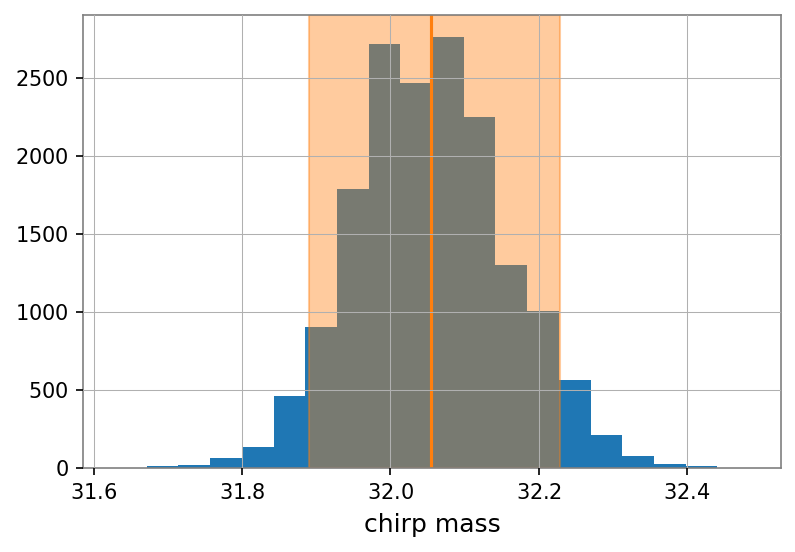

In [93]:
fig, ax = plt.subplots(dpi = 150)
ax.hist(result.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

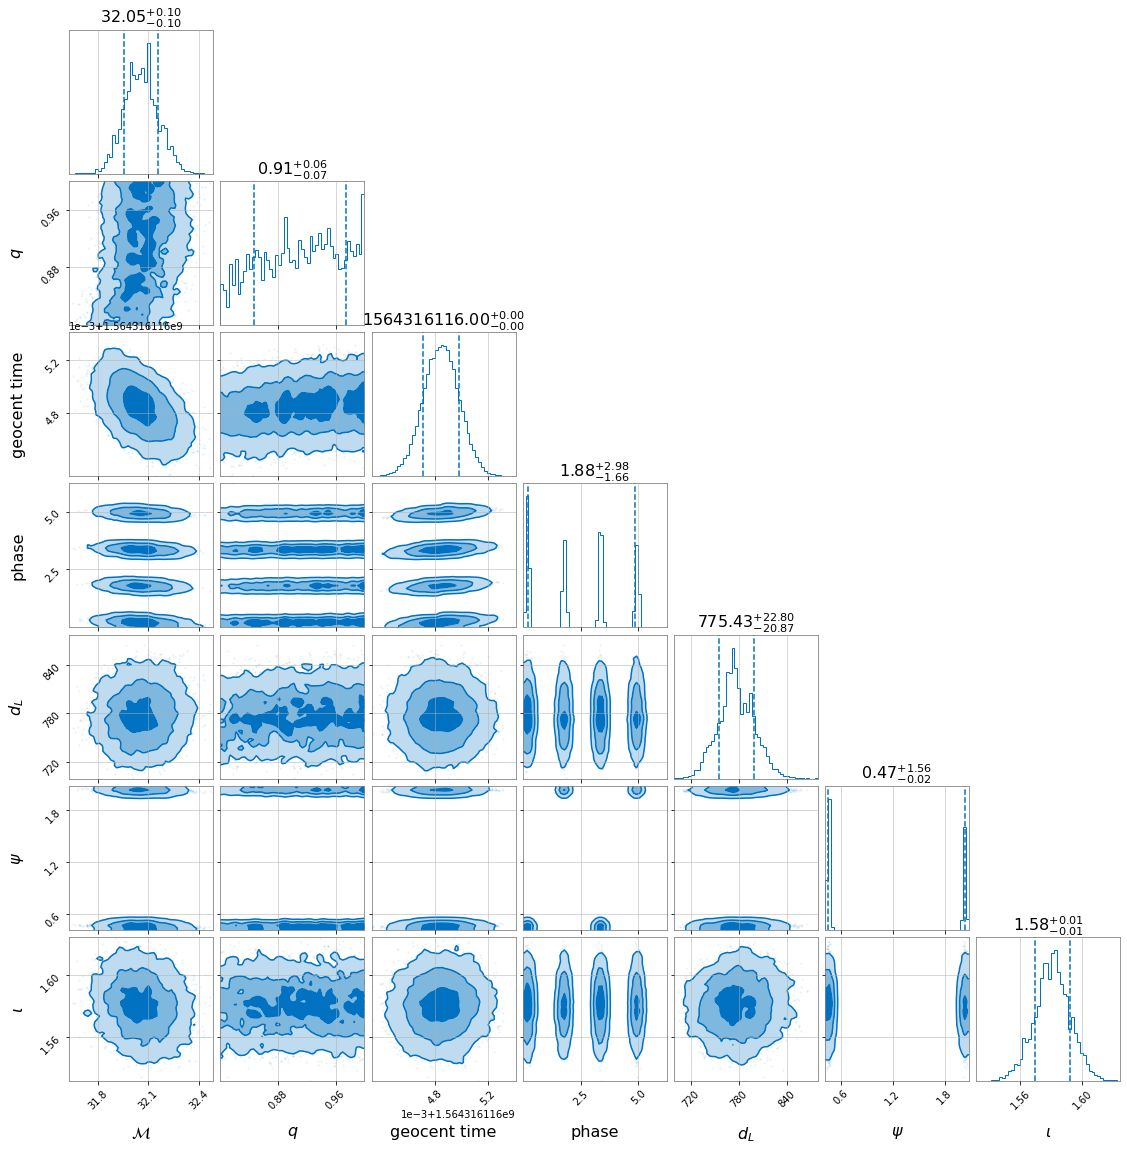

In [94]:
result.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase", "luminosity_distance", "psi", "theta_jn"], prior=True)

In [95]:
m1s = result.posterior['mass_1_source']
m2s = result.posterior['mass_2_source']
dl = result.posterior['luminosity_distance']
inclination = result.posterior['theta_jn']

In [96]:
dat = np.array([m1s, m2s, dl, inclination])

/usr/local/lib/python3.7/dist-packages/corner/core.py:668: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  ax.pcolor(X, Y, H.max() - H.T, cmap=density_cmap, **pcolor_kwargs)


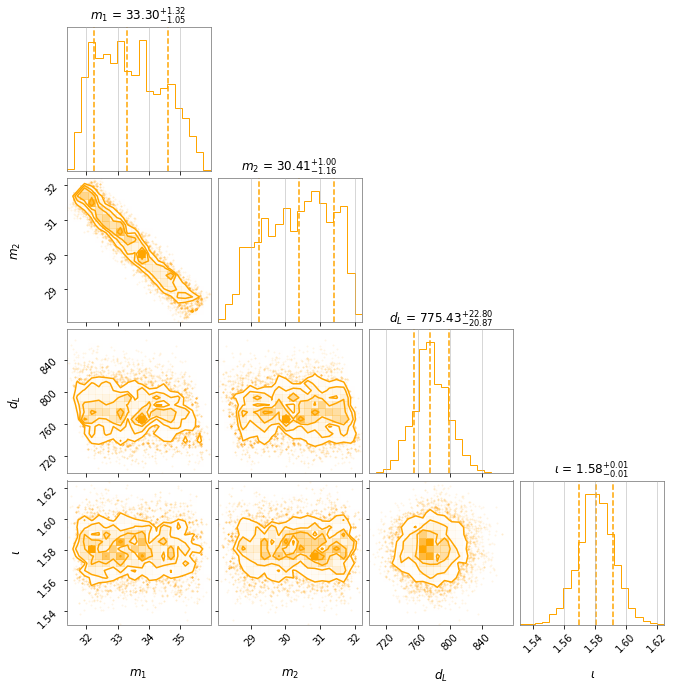

In [97]:
import corner

figure = corner.corner(
    dat.T,
    labels=[
        r"$m_1$",
        r"$m_2$",
        r"$d_L$",
        r"$\iota$",
    ],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True,
    title_kwargs={"fontsize": 12},
    color = 'orange',
    dpi = 150
)

<>:3: DeprecationWarning: invalid escape sequence \i
<>:5: DeprecationWarning: invalid escape sequence \i
<>:3: DeprecationWarning: invalid escape sequence \i
<>:5: DeprecationWarning: invalid escape sequence \i
<>:3: DeprecationWarning: invalid escape sequence \i
<>:5: DeprecationWarning: invalid escape sequence \i
<ipython-input-101-23310a667484>:3: DeprecationWarning: invalid escape sequence \i
  plt.title('2D Histogram $\iota$ vs $d_L$')
<ipython-input-101-23310a667484>:5: DeprecationWarning: invalid escape sequence \i
  plt.ylabel('$\iota$')


Text(0, 0.5, '$\\iota$')

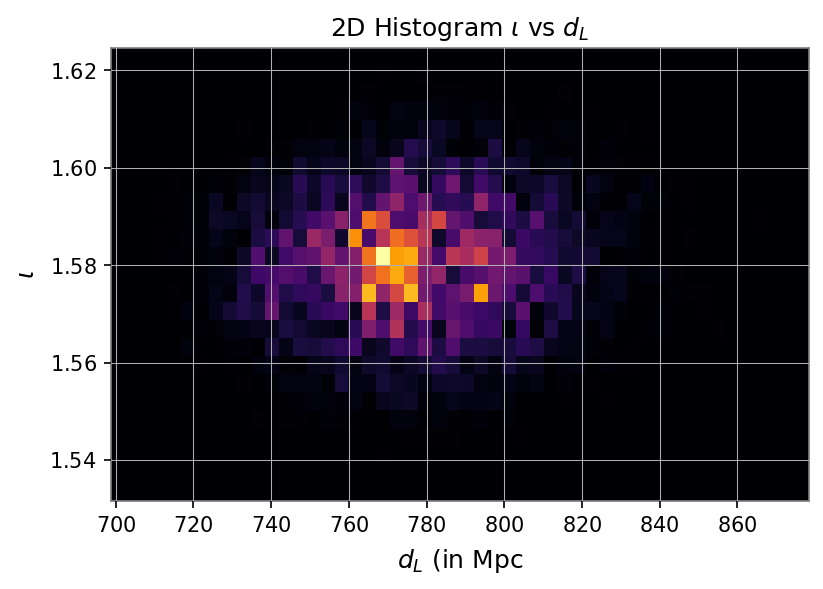

In [101]:
plt.figure(dpi = 150)
_ = plt.hist2d(dl, inclination, cmap = 'inferno', bins = [50,25], density = True)
plt.title('2D Histogram $\iota$ vs $d_L$')
plt.xlabel('$d_L$ (in Mpc')
plt.ylabel('$\iota$')

<>:6: DeprecationWarning: invalid escape sequence \i
<>:6: DeprecationWarning: invalid escape sequence \i
<>:6: DeprecationWarning: invalid escape sequence \i
<ipython-input-102-31b640f6ab37>:6: DeprecationWarning: invalid escape sequence \i
  plt.ylabel('$\iota$')
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


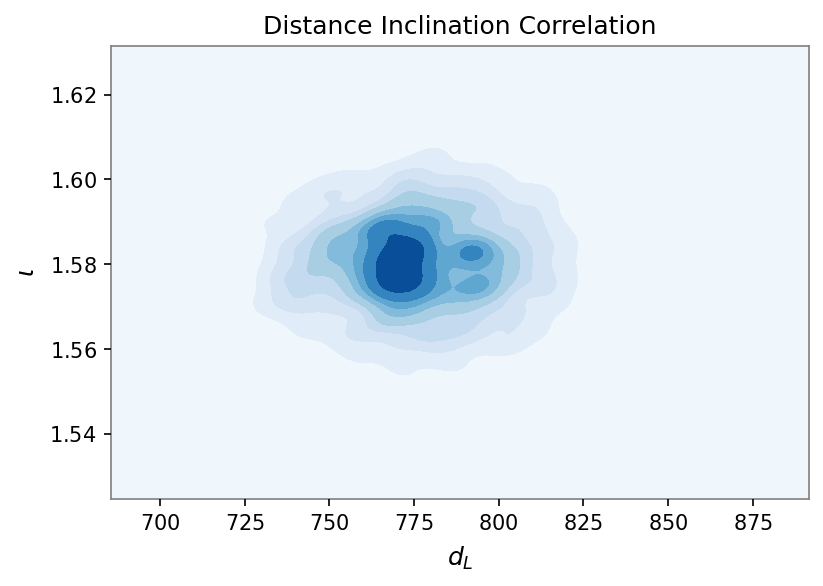

In [102]:
#marginal/joint plot
import seaborn as sns
plt.figure(dpi = 150)
sns.kdeplot(dl, inclination, cmap="Blues", shade=True, thresh=0)
plt.title("Distance Inclination Correlation")
plt.ylabel('$\iota$')
plt.xlabel('$d_L$')
plt.grid(False)

<>:6: DeprecationWarning: invalid escape sequence \m
<>:6: DeprecationWarning: invalid escape sequence \m
<>:6: DeprecationWarning: invalid escape sequence \m
<ipython-input-103-911ba3f8b4f1>:6: DeprecationWarning: invalid escape sequence \m
  plt.xlabel('$\mathcal{M}$')
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


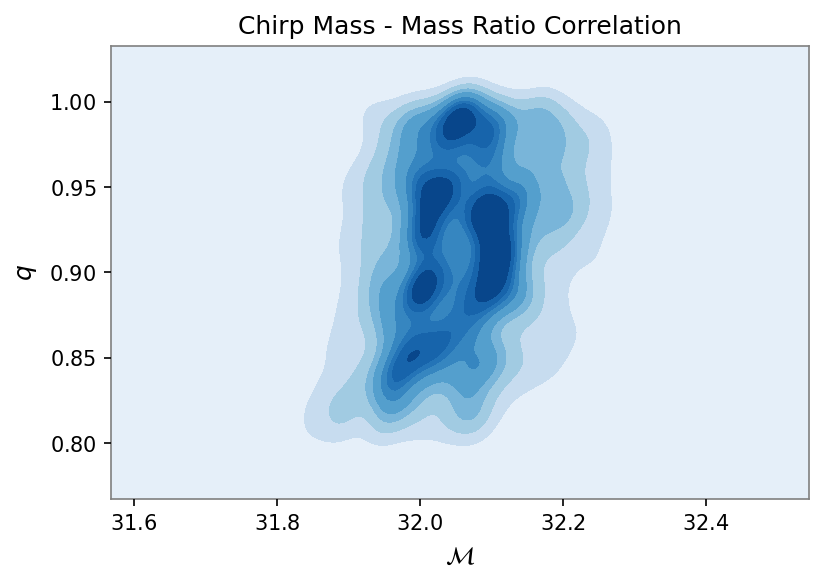

In [103]:
M = result.posterior['chirp_mass']
q = result.posterior['mass_ratio']
plt.figure(dpi = 150)
sns.kdeplot(M, q, cmap="Blues", shade=True, thresh=0)
plt.title("Chirp Mass - Mass Ratio Correlation")
plt.xlabel('$\mathcal{M}$')
plt.ylabel('$q$')
plt.grid(False)